In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn import preprocessing
import os, sys

# local imports
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from utils import *
from gtv import *
from preprocessing import *

In [3]:
# load data and compute covariance matrix
X = pd.read_csv('data/X_obs.csv').values
y = pd.read_csv('data/y_avg.csv').values.reshape(1,-1)[0]
Xlens = pd.read_csv('data/X_lens.csv').values
fts = pd.read_csv('data/sst_columns.csv')

Xlens = preprocessing.scale(Xlens)
Slens = Xlens.T@Xlens/Xlens.shape[0]
Dlens = edge_incidence(Slens, .5) # we threshold the covariance matrix at .5

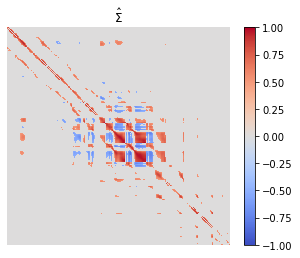

In [7]:
plot_covariance([threshold_covariance(Slens, .5)], ["$\hat{\Sigma}$"])

In [5]:
# split data into train/test
X_train = X[:50]
y_train = y[:50]
X_test = X[50:]
y_test = y[50:]

Before GTV, we can investigate the predictive performance of just using Nino 3.4 and NZI as univariate predictors in a linear regression model, and using Nino 3.4 & NZI together in a bivariate regression model. This is a good baseline to compare GTV performance with:

In [9]:
tele_df = teleconnections(np.vstack([X_train, X_test]), np.append(y_train, y_test), fts, .9)
tele_df

,Method,MSE,R2,Coefs,alpha
0,NZI,0.865319,0.234525,[-0.5804724951297076],0.9
1,Nino 3.4,0.981842,0.131446,[0.34361398500807017],0.9
2,Nino 3.4 & NZI,0.867096,0.232953,"[-0.5864973549813631, -0.006775971501037147]",0.9


In [14]:
df = gtv_cvx_path(X, y, Dlens, np.logspace(-1, 1, 20)/25, np.logspace(-3, -1, 20)/25, alpha=.9)
df['lambda_1'] = (df.lambda_1*10).round(2)
df['lambda_tv'] = df.lambda_tv*(10**3)#.round(2)

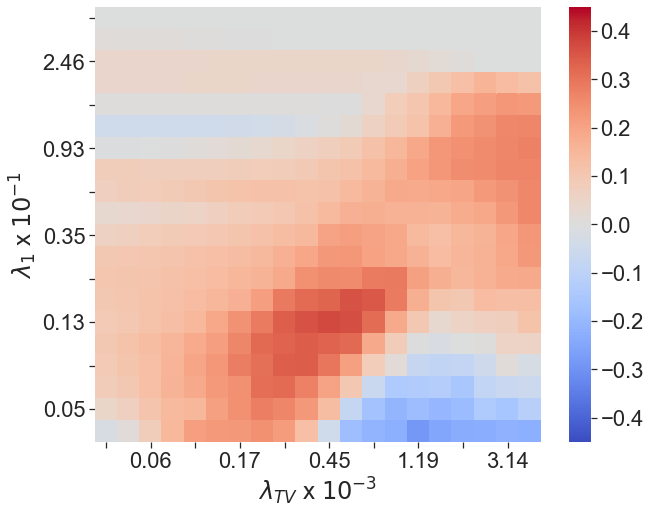

In [17]:
draw_lambda_contour_paper_format(df.round(5), 'r2', vmin=-.45, vmax=.45)

0.0103 0.0004


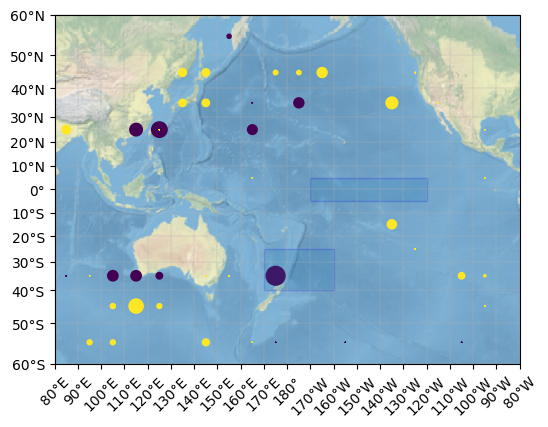

0.34504297159390485


In [19]:
(errors, l1, ltv) = gtv_cv(X_train, y_train, Dlens, .9, np.linspace(.01, 1, 5)/25, np.logspace(-2, -1, 5)/25)
print(l1, ltv)
beta = gtv_cvx(X_train, y_train, Dlens, lambda_lasso=l1, lambda_tv=ltv, alpha=.9)

# plot the solution
fts['coef'] = beta/2
plot_coefs(fts)

print(r2_score(y_test, X_test@beta))

In [6]:
beta = gtv_cvx(X_train, y_train, Dlens, lambda_lasso=.0103, lambda_tv=.0004, alpha=.9)

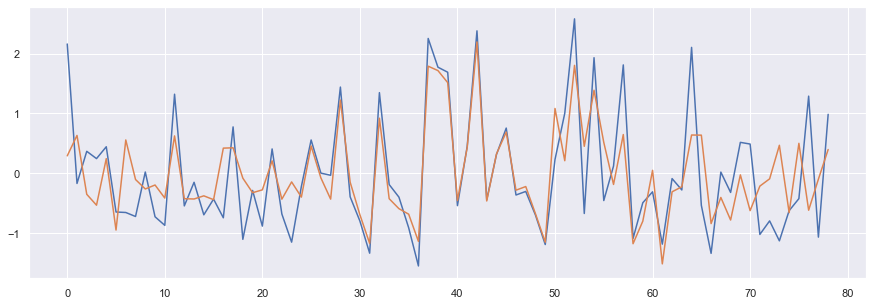

In [8]:
sns.set()
plt.figure(figsize=(15,5))
plt.plot(y)
plt.plot(X@beta)